In [4]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from scipy.stats import linregress

# Impor the OpenWeatherMap API key
from api_key import key
from geoapi import geo_apikey


In [5]:
#https://api.census.gov/data/2019/acs/acs5?get=NAME,group(B01003)&for=city:*&key=YOUR_API_KEY

import requests
import json
# Set base URL
base_url = "https://api.census.gov/data"
year = '/2022'
data_name = '/acs/acs1/subject'
#all of the B02015 table ID data for all states
#qry = '?get=group(S1903)&for=place'
qry = "?get=NAME,S1903_C03_001E&for=place"
key = str('&key='+ key)

    # Make an API request using the params dictionary
test = str(base_url + year + data_name + qry + key)
test
response = requests.get(base_url + year + data_name + qry + key)
result = response.json()
print (json.dumps(result, indent=4))


[
    [
        "NAME",
        "S1903_C03_001E",
        "state",
        "place"
    ],
    [
        "Auburn city, Alabama",
        "54839",
        "01",
        "03076"
    ],
    [
        "Birmingham city, Alabama",
        "39326",
        "01",
        "07000"
    ],
    [
        "Dothan city, Alabama",
        "53929",
        "01",
        "21184"
    ],
    [
        "Hoover city, Alabama",
        "103194",
        "01",
        "35896"
    ],
    [
        "Huntsville city, Alabama",
        "68930",
        "01",
        "37000"
    ],
    [
        "Mobile city, Alabama",
        "50051",
        "01",
        "50000"
    ],
    [
        "Montgomery city, Alabama",
        "55108",
        "01",
        "51000"
    ],
    [
        "Tuscaloosa city, Alabama",
        "49005",
        "01",
        "77256"
    ],
    [
        "Anchorage municipality, Alaska",
        "100751",
        "02",
        "03000"
    ],
    [
        "Avondale city, Arizona",
        "66801

In [6]:
#https://www.pgpf.org/blog/2023/11/income-and-wealth-in-the-united-states-an-overview-of-recent-data#:~:text=According%20to%20the%20ASEC%2C%20median,the%20pandemic%20and%20subsequent%20recession.
median_income = 74580
# Check if the request was successful
if response.status_code == 200:
    data = response.json()
    
    # Convert JSON data to DataFrame
    df = pd.DataFrame(data[1:], columns=data[0:])
    
    # Save the DataFrame to a CSV file
    df.to_csv("../data/census_data.csv", index=False)
    print("Data saved to census_data.csv")
else:
    print("Error:", response.status_code)

Data saved to census_data.csv


In [7]:
# Convert the cities weather data into a Pandas DataFrame
city_eco_data_df  = pd.read_csv('../data/census_data.csv')

# Splitting the 'NAME' column into two columns 'City' and 'State'
city_eco_data_df[['City', 'State']] = city_eco_data_df['NAME'].str.split(', ', expand=True)
#city_eco_data_df.drop(columns=['NAME'], inplace=True)

# Show Record Count
city_eco_data_df.count()
city_eco_data_df.head()

,NAME,S1903_C03_001E,state,place,City,State
0,"Auburn city, Alabama",54839,1,3076,Auburn city,Alabama
1,"Birmingham city, Alabama",39326,1,7000,Birmingham city,Alabama
2,"Dothan city, Alabama",53929,1,21184,Dothan city,Alabama
3,"Hoover city, Alabama",103194,1,35896,Hoover city,Alabama
4,"Huntsville city, Alabama",68930,1,37000,Huntsville city,Alabama


In [8]:
## splitting the eco median data into low income and high income..
city_eco_data_df = pd.DataFrame(city_eco_data_df)
city_eco_data_df = city_eco_data_df.drop_duplicates()
#city_eco_data_df = city_eco_data_df.drop_duplicates(subset=['City'])
# Splitting the DataFrame into two based on the condition
threshold_value = 74580
df_above_threshold = city_eco_data_df[city_eco_data_df['S1903_C03_001E'] > threshold_value]
df_below_threshold = city_eco_data_df[city_eco_data_df['S1903_C03_001E'] <= threshold_value]

len(city_eco_data_df), len(df_below_threshold), len(df_below_threshold)
#df_above_threshold, df_below_threshold


(646, 320, 320)

In [9]:
#the Geoapify Geocoding service URL for getting Coords for the City list extracted from the Census Data
def get_coordinates(city_name, geo_apikey):
    base_url = "https://api.geoapify.com/v1/geocode/search"
    params = {
        "text": city_name,
        "apiKey": geo_apikey
    }

    response = requests.get(base_url, params=params)
    if response.status_code == 200:
        data = response.json()
        if data['features']:
            # Extracting the first result's coordinates
            coordinates = data['features'][0]['geometry']['coordinates']
            return coordinates
        else:
            return "No results found"
    else:
        return "Error in API request"

# pull the data
api_key = geo_apikey # Replace with your actual Geoapify API key
city_name1 = "New York"
coordinates = get_coordinates(city_name1, api_key)
print(f"Coordinates of {city_name1}: {coordinates}")

Coordinates of New York: [-74.0060152, 40.7127281]


In [10]:
# Path to the CSV file
coord_csv_file_path = "../data/city_coordinates.csv"

# Read and display the first few rows of the saved CSV file for verification
city_coordinates_df = pd.read_csv(coord_csv_file_path)
print(city_coordinates_df.head())

                       City   Latitude  Longitude
0      Auburn city, Alabama  32.601014 -85.516657
1  Birmingham city, Alabama  33.599853 -86.632216
2      Dothan city, Alabama  31.221808 -85.378001
3      Hoover city, Alabama  33.387197 -86.805680
4  Huntsville city, Alabama  34.729847 -86.585901


In [11]:
### process and compare a list of the eco data, and run it against the geoapify data.
## if the file already exists from a previous run...
## it will then check if the city has been extracted with coords from geoapify 

# Check if the CSV file already exists and read it, else create a new DataFrame
try:
    existing_data_df = city_coordinates_df
except FileNotFoundError:
    existing_data_df = pd.DataFrame(columns=['City', 'Latitude', 'Longitude'])

# Write headers to the CSV file if it's empty
if existing_data_df.empty:
    existing_data_df.to_csv(coord_csv_file_path, index=False)

# Iterating through the cities and fetching coordinates
for city in city_eco_data_df['NAME']:
    # Check if the city is already in the existing data
    if city not in existing_data_df['City'].values:
        coordinates = get_coordinates(city, api_key)
        if coordinates != [None, None]:
            # Creating a DataFrame for the current city
            temp_df = pd.DataFrame([{
                'City': city,
                'Latitude': coordinates[1],  # Latitude
                'Longitude': coordinates[0]  # Longitude
            }])
            
            # Append the current city's data to the CSV file
            temp_df.to_csv(coord_csv_file_path, mode='a', header=False, index=False)
            print(f"Getting data for {city}")
        else:
            print(f"Failed to fetch coordinates for {city}")
    else:
        print(f"{city} already exists in the dataset.")


Auburn city, Alabama already exists in the dataset.
Birmingham city, Alabama already exists in the dataset.
Dothan city, Alabama already exists in the dataset.
Hoover city, Alabama already exists in the dataset.
Huntsville city, Alabama already exists in the dataset.
Mobile city, Alabama already exists in the dataset.
Montgomery city, Alabama already exists in the dataset.
Tuscaloosa city, Alabama already exists in the dataset.
Anchorage municipality, Alaska already exists in the dataset.
Avondale city, Arizona already exists in the dataset.
Buckeye city, Arizona already exists in the dataset.
Casas Adobes CDP, Arizona already exists in the dataset.
Chandler city, Arizona already exists in the dataset.
Flagstaff city, Arizona already exists in the dataset.
Gilbert town, Arizona already exists in the dataset.
Glendale city, Arizona already exists in the dataset.
Goodyear city, Arizona already exists in the dataset.
Maricopa city, Arizona already exists in the dataset.
Mesa city, Arizona

In [12]:
# Read and display the first few rows of the saved CSV file for verification
city_coordinates_df = pd.read_csv(coord_csv_file_path)
city_coordinates_df = city_coordinates_df.drop_duplicates()
print(city_coordinates_df.head())

                       City   Latitude  Longitude
0      Auburn city, Alabama  32.601014 -85.516657
1  Birmingham city, Alabama  33.599853 -86.632216
2      Dothan city, Alabama  31.221808 -85.378001
3      Hoover city, Alabama  33.387197 -86.805680
4  Huntsville city, Alabama  34.729847 -86.585901


In [13]:
#verify data frame record counts
print(str(len(city_coordinates_df)) + ' compared to the source list length of: ' + str(len(city_eco_data_df)))


646 compared to the source list length of: 646


# using the csv previously created on first run to save time during testing/processing this code
# if this is the first time running, create a blank csv in the location listed below, with the name as shown.
high_inc_merged_df = pd.read_csv("../data/high_inc_data.csv")
low_inc_merged_df = pd.read_csv("../data/low_inc_data.csv")
df_above_threshold.columns
high_inc_merged_df.columns

In [14]:
import pandas as pd

# Creating empty dataframes for high_inc_merged_df and low_inc_merged_df
high_inc_merged_df = pd.DataFrame()
low_inc_merged_df = pd.DataFrame()

# Displaying the empty dataframes
high_inc_merged_df, low_inc_merged_df

(Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [])

In [15]:
# Join the median range above/below threshold DFs to the Coords city DataFrames on the city names
# Check if the merge has already been done for high income dataframe
if 'City_x' not in high_inc_merged_df.columns:
    high_inc_merged_df = df_above_threshold.merge(city_coordinates_df, left_on='NAME', right_on='City')
    high_inc_merged_df = high_inc_merged_df.rename(columns={'S1903_C03_001E': 'High_med_inc'})
else:
    high_inc_merged_df = high_inc_merged_df

# Check if the merge has already been done for low income dataframe
if 'City_x' not in low_inc_merged_df.columns:
    low_inc_merged_df = df_below_threshold.merge(city_coordinates_df, left_on='NAME', right_on='City')
    low_inc_merged_df = low_inc_merged_df.rename(columns={'S1903_C03_001E': 'Low_med_inc'})
else:
    low_inc_merged_df = low_inc_merged_df

high_inc_merged_df, low_inc_merged_df

(                               NAME  High_med_inc  state  place  \
 0              Hoover city, Alabama        103194      1  35896   
 1    Anchorage municipality, Alaska        100751      2   3000   
 2             Buckeye city, Arizona         95235      4   7940   
 3         Casas Adobes CDP, Arizona         75650      4  10670   
 4            Chandler city, Arizona         98664      4  12000   
 ..                              ...           ...    ...    ...   
 321      South Hill CDP, Washington        109848     53  65922   
 322         Tacoma city, Washington         80784     53  70000   
 323      Vancouver city, Washington         76799     53  74060   
 324        Appleton city, Wisconsin         75262     55   2375   
 325        Waukesha city, Wisconsin         74675     55  84250   
 
                      City_x       State                          City_y  \
 0               Hoover city     Alabama            Hoover city, Alabama   
 1    Anchorage municipality  

In [20]:
import requests
import os

def add_place_details_to_df(df, geoapifykey):
     # Check if the file exists
    if not os.path.exists("../data/low_inc_merged_df.csv"):
        radius = 6600  # 4 miles
        categories = "commercial.weapons,activity.sport_club,commercial.smoking,commercial.food_and_drink.health_food"
        print("Starting search for specified categories")

        for index, row in df.iterrows():
            lat, lon = row['Latitude'], row['Longitude']

            params = {
                "apiKey": geoapifykey,
                "categories": categories,
                "filter": f"circle:{lon},{lat},{radius}",
                "bias": f"proximity:{lon},{lat}",
                "limit": 100  # Adjust this value as needed; check API documentation for maximum allowed limit
            }

            base_url = "https://api.geoapify.com/v2/places"
            response = requests.get(base_url, params=params)
            places = response.json()

        # Initialize counts for each category
            category_counts = {
                'commercial.weapons': 0, 
                'activity.sport_club': 0, 
                'commercial.smoking': 0, 
                'commercial.food_and_drink.health_food': 0
            }

            for feature in places.get("features", []):
                feature_categories = feature["properties"]["categories"]
                for category in category_counts.keys():
                    if category in feature_categories:
                        category_counts[category] += 1

        # Store counts in dataframe
            for category, count in category_counts.items():
                df.loc[index, f"{category} Count"] = count

            print(f"{row['NAME']} - Counts: {category_counts}")

# Replace 'geo_apikey' with your actual Geoapify API key
geoapifykey = geo_apikey

# Process the dataframes
add_place_details_to_df(high_inc_merged_df, geoapifykey)
add_place_details_to_df(low_inc_merged_df, geoapifykey)

#If running the first time, you should uncomment this and save the data from the API pull locally
high_inc_merged_df.to_csv("../data/high_inc_merged_df.csv", mode='w', header=True, index=False)
low_inc_merged_df.to_csv("../data/low_inc_merged_df.csv", mode='w', header=True, index=False)

In [21]:
high_inc_merged_df = pd.read_csv("../data/high_inc_merged_df.csv")
low_inc_merged_df = pd.read_csv("../data/low_inc_merged_df.csv")

In [22]:
#display records with store counts returned from search
filtered_df = low_inc_merged_df[low_inc_merged_df['commercial.weapons Count'] > 0]

# Displaying the filtered dataframe
filtered_df

,NAME,Low_med_inc,state,place,City_x,State,City_y,Latitude,Longitude,commercial.weapons Count,activity.sport_club Count,commercial.smoking Count,commercial.food_and_drink.health_food Count
9,"Glendale city, Arizona",72411,4,27820,Glendale city,Arizona,"Glendale city, Arizona",33.538686,-112.185994,1.0,0.0,5.0,0.0
14,"Fort Smith city, Arkansas",47669,5,24550,Fort Smith city,Arkansas,"Fort Smith city, Arkansas",35.384996,-94.425305,1.0,0.0,1.0,0.0
23,"Bellflower city, California",74131,6,4982,Bellflower city,California,"Bellflower city, California",33.883545,-118.121959,1.0,2.0,7.0,0.0
32,"Hawthorne city, California",73515,6,32548,Hawthorne city,California,"Hawthorne city, California",33.918533,-118.354297,2.0,1.0,9.0,0.0
35,"Inglewood city, California",62601,6,36546,Inglewood city,California,"Inglewood city, California",33.965104,-118.339544,2.0,0.0,4.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
302,"Spokane city, Washington",62287,53,67000,Spokane city,Washington,"Spokane city, Washington",47.661095,-117.413870,3.0,2.0,23.0,0.0
303,"Spokane Valley city, Washington",66484,53,67167,Spokane Valley city,Washington,"Spokane Valley city, Washington",47.656552,-117.267696,1.0,0.0,11.0,0.0
304,"Yakima city, Washington",56821,53,80010,Yakima city,Washington,"Yakima city, Washington",46.618755,-120.578637,1.0,0.0,2.0,0.0
313,"Cheyenne city, Wyoming",70597,56,13900,Cheyenne city,Wyoming,"Cheyenne city, Wyoming",41.118187,-104.769403,2.0,0.0,0.0,1.0


In [23]:
#high_inc_merged_df.to_csv('../data/high_inc_data.csv', index=False)
high_inc_merged_df

,NAME,High_med_inc,state,place,City_x,State,City_y,Latitude,Longitude,commercial.weapons Count,activity.sport_club Count,commercial.smoking Count,commercial.food_and_drink.health_food Count
0,"Hoover city, Alabama",103194,1,35896,Hoover city,Alabama,"Hoover city, Alabama",33.387197,-86.805680,1.0,0.0,0.0,0.0
1,"Anchorage municipality, Alaska",100751,2,3000,Anchorage municipality,Alaska,"Anchorage municipality, Alaska",61.216313,-149.894852,1.0,2.0,21.0,0.0
2,"Buckeye city, Arizona",95235,4,7940,Buckeye city,Arizona,"Buckeye city, Arizona",33.370320,-112.583776,0.0,0.0,0.0,0.0
3,"Casas Adobes CDP, Arizona",75650,4,10670,Casas Adobes CDP,Arizona,"Casas Adobes CDP, Arizona",32.340932,-111.010201,0.0,0.0,1.0,0.0
4,"Chandler city, Arizona",98664,4,12000,Chandler city,Arizona,"Chandler city, Arizona",33.306203,-111.841185,7.0,3.0,9.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
321,"South Hill CDP, Washington",109848,53,65922,South Hill CDP,Washington,"South Hill CDP, Washington",47.120551,-122.283781,0.0,0.0,4.0,0.0
322,"Tacoma city, Washington",80784,53,70000,Tacoma city,Washington,"Tacoma city, Washington",47.282117,-122.479299,3.0,3.0,13.0,0.0
323,"Vancouver city, Washington",76799,53,74060,Vancouver city,Washington,"Vancouver city, Washington",45.625378,-122.675514,1.0,0.0,10.0,0.0
324,"Appleton city, Wisconsin",75262,55,2375,Appleton city,Wisconsin,"Appleton city, Wisconsin",44.262263,-88.406913,1.0,0.0,3.0,1.0


# This is optional if we also want to measure the distance as a variable instead of just count of locations / income
# Calculate distances to each store based from center city coords to store coords

from math import radians, cos, sin, asin, sqrt
import ast

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance in kilometers between two points 
    on the earth (specified in decimal degrees)
    """
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371  # Radius of earth in kilometers
    return c * r

def calculate_distances(df):
    if 'Closest Store Distance' not in df.columns and 'Furthest Store Distance' not in df.columns:
        for index, row in df.iterrows():
            poi_lat, poi_lon = row['Latitude'], row['Longitude']
            store_coordinates = ast.literal_eval(row['Store Coordinates'])

            closest_distance = float('inf')
            furthest_distance = 0
            closest_store = None
            furthest_store = None

            for coordinates in store_coordinates:
                store_lon, store_lat = coordinates
                distance = haversine(poi_lon, poi_lat, store_lon, store_lat)
                if distance < closest_distance:
                    closest_distance = distance
                    closest_store = coordinates
                if distance > furthest_distance:
                    furthest_distance = distance
                    furthest_store = coordinates

            df.loc[index, 'Closest Store Distance'] = closest_distance
            df.loc[index, 'Furthest Store Distance'] = furthest_distance
            df.loc[index, 'Closest Store Coordinates'] = str(closest_store)
            df.loc[index, 'Furthest Store Coordinates'] = str(furthest_store)

            print(f"Row {index}: Closest Store is at {closest_store} with a distance of {closest_distance} km")
            print(f"Row {index}: Furthest Store is at {furthest_store} with a distance of {furthest_distance} km")

# Apply to high income and low income dataframes
calculate_distances(high_inc_merged_df)
calculate_distances(low_inc_merged_df)

In [25]:
# Cleaning data frame from unusable values of NaN/Inf.. May consider different store type to have cleaner data

import numpy as np
import pandas as pd

# Replace NaN and None with 0
high_inc_merged_clean_df = high_inc_merged_df.fillna(0)
low_inc_merged_clean_df = low_inc_merged_df.fillna(0)

# Replace Inf and -Inf with 0
high_inc_merged_clean_df = high_inc_merged_clean_df.replace([np.inf, -np.inf], 0)
low_inc_merged_clean_df = low_inc_merged_clean_df.replace([np.inf, -np.inf], 0)

# Assuming the column for income is named 'Income'
# Calculate the 30th and 70th percentile values
percentile_30 = high_inc_merged_clean_df['High_med_inc'].quantile(0.3)
percentile_70 = high_inc_merged_clean_df['High_med_inc'].quantile(0.7)

low_percentile_30 = low_inc_merged_clean_df['Low_med_inc'].quantile(0.3)
low_percentile_70 = low_inc_merged_clean_df['Low_med_inc'].quantile(0.7)

# Filter the dataframes
# For high income (upper 30%)
high_inc_merged_clean_df = high_inc_merged_clean_df[high_inc_merged_clean_df['High_med_inc'] > percentile_70]

# For low income (lower 30%)
low_inc_merged_clean_df = low_inc_merged_clean_df[low_inc_merged_clean_df['Low_med_inc'] < low_percentile_30]

high_inc_merged_clean_df

,NAME,High_med_inc,state,place,City_x,State,City_y,Latitude,Longitude,commercial.weapons Count,activity.sport_club Count,commercial.smoking Count,commercial.food_and_drink.health_food Count
5,"Gilbert town, Arizona",111393,4,27400,Gilbert town,Arizona,"Gilbert town, Arizona",33.352763,-111.789037,17.0,7.0,19.0,0.0
11,"Queen Creek town, Arizona",129605,4,58150,Queen Creek town,Arizona,"Queen Creek town, Arizona",33.266924,-111.644313,1.0,1.0,0.0,0.0
17,"Alameda city, California",131116,6,562,Alameda city,California,"Alameda city, California",37.766461,-122.243496,0.0,5.0,10.0,4.0
21,"Brentwood city, California",132610,6,8142,Brentwood city,California,"Brentwood city, California",34.052140,-118.474070,0.0,4.0,40.0,1.0
25,"Carlsbad city, California",146596,6,11194,Carlsbad city,California,"Carlsbad city, California",33.164760,-117.340316,0.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
314,"Kirkland city, Washington",130620,53,35940,Kirkland city,Washington,"Kirkland city, Washington",47.676213,-122.191216,2.0,2.0,13.0,2.0
317,"Redmond city, Washington",152851,53,57535,Redmond city,Washington,"Redmond city, Washington",47.657629,-122.089065,2.0,0.0,6.0,0.0
319,"Sammamish city, Washington",223849,53,61115,Sammamish city,Washington,"Sammamish city, Washington",47.601755,-122.041684,0.0,0.0,2.0,0.0
320,"Seattle city, Washington",115409,53,63000,Seattle city,Washington,"Seattle city, Washington",47.617708,-122.344462,0.0,2.0,53.0,0.0


In [26]:
low_inc_merged_clean_df

,NAME,Low_med_inc,state,place,City_x,State,City_y,Latitude,Longitude,commercial.weapons Count,activity.sport_club Count,commercial.smoking Count,commercial.food_and_drink.health_food Count
1,"Birmingham city, Alabama",39326,1,7000,Birmingham city,Alabama,"Birmingham city, Alabama",33.599853,-86.632216,0.0,1.0,1.0,1.0
4,"Mobile city, Alabama",50051,1,50000,Mobile city,Alabama,"Mobile city, Alabama",30.689362,-88.051896,0.0,0.0,0.0,0.0
6,"Tuscaloosa city, Alabama",49005,1,77256,Tuscaloosa city,Alabama,"Tuscaloosa city, Alabama",33.175708,-87.533106,0.0,0.0,1.0,0.0
10,"Tucson city, Arizona",51281,4,77000,Tucson city,Arizona,"Tucson city, Arizona",32.222622,-110.974774,0.0,0.0,1.0,0.0
13,"Fayetteville city, Arkansas",52991,5,23290,Fayetteville city,Arkansas,"Fayetteville city, Arkansas",36.061667,-94.161139,0.0,0.0,4.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,"Caguas zona urbana, Puerto Rico",22060,72,10334,Caguas zona urbana,Puerto Rico,"Caguas zona urbana, Puerto Rico",18.338810,-67.251630,0.0,0.0,4.0,1.0
316,"Carolina zona urbana, Puerto Rico",36646,72,14290,Carolina zona urbana,Puerto Rico,"Carolina zona urbana, Puerto Rico",18.407670,-65.981020,0.0,1.0,3.0,1.0
317,"Guaynabo zona urbana, Puerto Rico",48081,72,32522,Guaynabo zona urbana,Puerto Rico,"Guaynabo zona urbana, Puerto Rico",18.380340,-67.188390,0.0,0.0,0.0,0.0
318,"Ponce zona urbana, Puerto Rico",16795,72,63820,Ponce zona urbana,Puerto Rico,"Ponce zona urbana, Puerto Rico",18.338810,-67.251630,0.0,0.0,4.0,1.0


In [27]:
#save the DFs as physical copies to work from
high_inc_merged_clean_df.to_csv("../data/high_inc_data_final.csv", mode='w', header=True, index=False)
low_inc_merged_clean_df.to_csv("../data/low_inc_data_final.csv", mode='w', header=True, index=False)

What, if any, correlation is there between category/activity count and income level?

In [29]:
import scipy.stats as st

categories = ["commercial.weapons", "activity.sport_club", "commercial.smoking", "commercial.food_and_drink.health_food"]

# Analyzing correlations for high income dataframe
print("High Income Dataframe Correlations:")
for category in categories:
    category_count_high = high_inc_merged_clean_df[f'{category} Count']
    high_med_inc = high_inc_merged_clean_df["High_med_inc"]
    correlation_coefficient_high = st.pearsonr(high_med_inc, category_count_high)[0]
    print(f"The correlation coefficient between higher income and amount of {category}: {round(correlation_coefficient_high, 2)}")

# Analyzing correlations for low income dataframe
print("\nLow Income Dataframe Correlations:")
for category in categories:
    category_count_low = low_inc_merged_clean_df[f'{category} Count']
    low_med_inc = low_inc_merged_clean_df["Low_med_inc"]
    correlation_coefficient_low = st.pearsonr(low_med_inc, category_count_low)[0]
    print(f"The correlation coefficient between lower income and amount of {category}: {round(correlation_coefficient_low, 2)}")


High Income Dataframe Correlations:
The correlation coefficient between higher income and amount of commercial.weapons: -0.06
The correlation coefficient between higher income and amount of activity.sport_club: -0.02
The correlation coefficient between higher income and amount of commercial.smoking: -0.04
The correlation coefficient between higher income and amount of commercial.food_and_drink.health_food: 0.01

Low Income Dataframe Correlations:
The correlation coefficient between lower income and amount of commercial.weapons: 0.08
The correlation coefficient between lower income and amount of activity.sport_club: -0.09
The correlation coefficient between lower income and amount of commercial.smoking: -0.02
The correlation coefficient between lower income and amount of commercial.food_and_drink.health_food: -0.14


There is weak correlation between the category type and income level across all comparisons except for health food stores. That indicates there are far fewer health food options for low income areas as compared to other category types. 

Also, the difference in correlation between weapons stores indicates there may be a relatively weak correlation between amount of store types and income level, but the difference between the high and low correlation may indicate the trend leaning towards lower- middle class. 

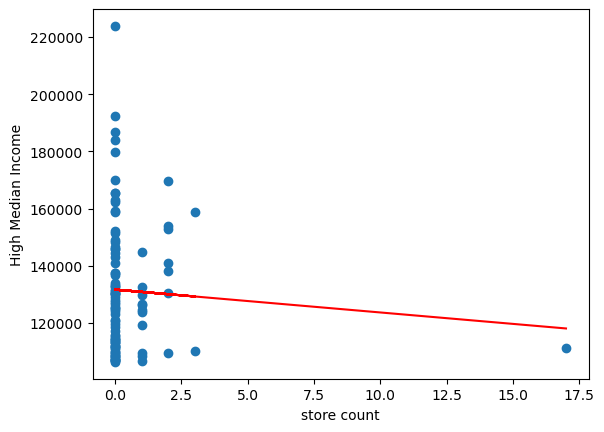

In [30]:
import matplotlib.pyplot as plt
from scipy.stats import linregress
# Add the linear regression equation and line to plot
x_values = high_inc_merged_clean_df["commercial.weapons Count"]
y_values = high_inc_merged_clean_df["High_med_inc"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(5.8,0.8),fontsize=15,color="red")
plt.xlabel('store count')
plt.ylabel('High Median Income')
plt.show()

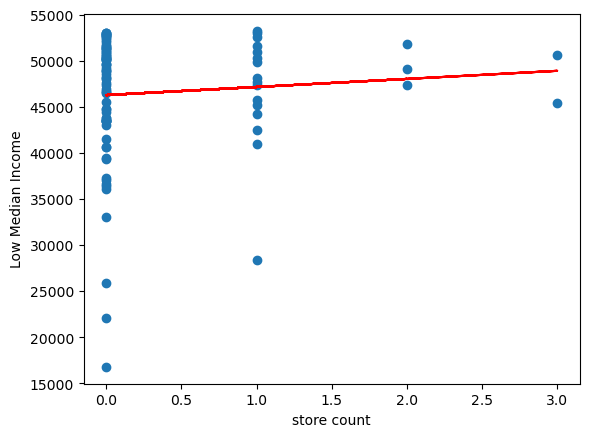

In [47]:
import matplotlib.pyplot as plt
from scipy.stats import linregress
# Add the linear regression equation and line to plot
x_values = low_inc_merged_clean_df["commercial.weapons Count"]
y_values = low_inc_merged_clean_df["Low_med_inc"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(5.8,0.8),fontsize=15,color="red")
plt.xlabel('store count')
plt.ylabel('Low Median Income')
plt.show()

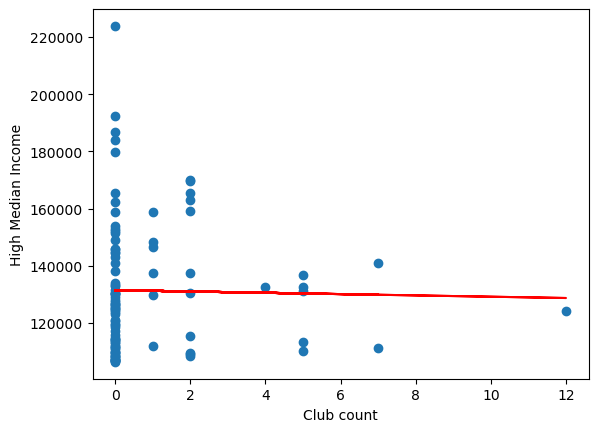

In [48]:
import matplotlib.pyplot as plt
from scipy.stats import linregress
# Add the linear regression equation and line to plot
x_values = high_inc_merged_clean_df["activity.sport_club Count"]
y_values = high_inc_merged_clean_df["High_med_inc"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(5.8,0.8),fontsize=15,color="red")
plt.xlabel('Club count')
plt.ylabel('High Median Income')
plt.show()

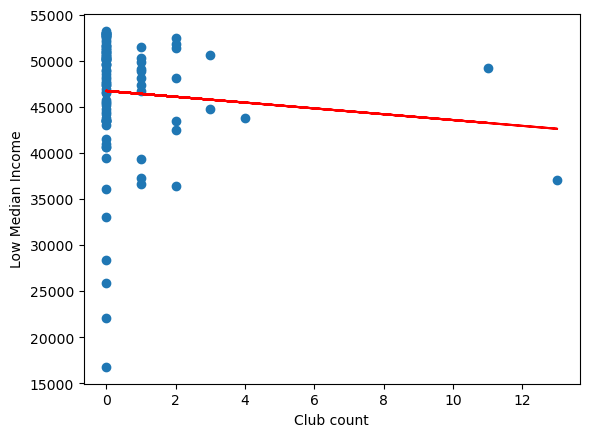

In [49]:
import matplotlib.pyplot as plt
from scipy.stats import linregress
# Add the linear regression equation and line to plot
x_values = low_inc_merged_clean_df["activity.sport_club Count"]
y_values = low_inc_merged_clean_df["Low_med_inc"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(5.8,0.8),fontsize=15,color="red")
plt.xlabel('Club count')
plt.ylabel('Low Median Income')
plt.show()

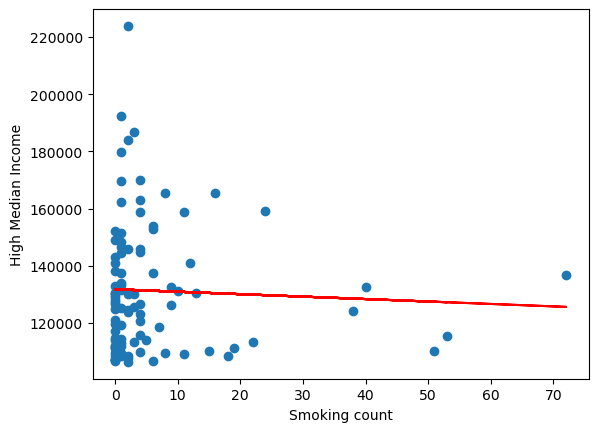

In [50]:
import matplotlib.pyplot as plt
from scipy.stats import linregress
# Add the linear regression equation and line to plot
x_values = high_inc_merged_clean_df["commercial.smoking Count"]
y_values = high_inc_merged_clean_df["High_med_inc"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(5.8,0.8),fontsize=15,color="red")
plt.xlabel('Smoking count')
plt.ylabel('High Median Income')
plt.show()

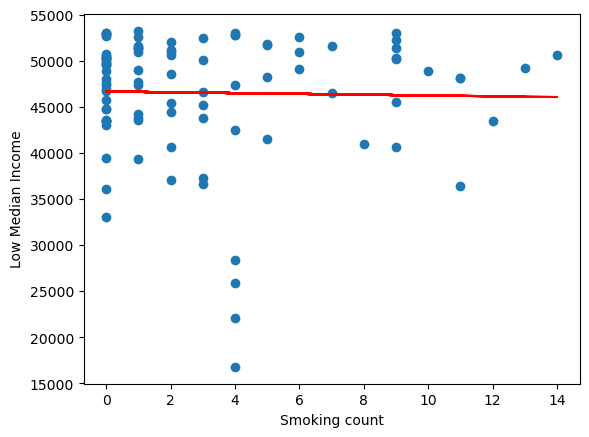

In [31]:
import matplotlib.pyplot as plt
from scipy.stats import linregress
# Add the linear regression equation and line to plot
x_values = low_inc_merged_clean_df["commercial.smoking Count"]
y_values = low_inc_merged_clean_df["Low_med_inc"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(5.8,0.8),fontsize=15,color="red")
plt.xlabel('Smoking count')
plt.ylabel('Low Median Income')
plt.show()

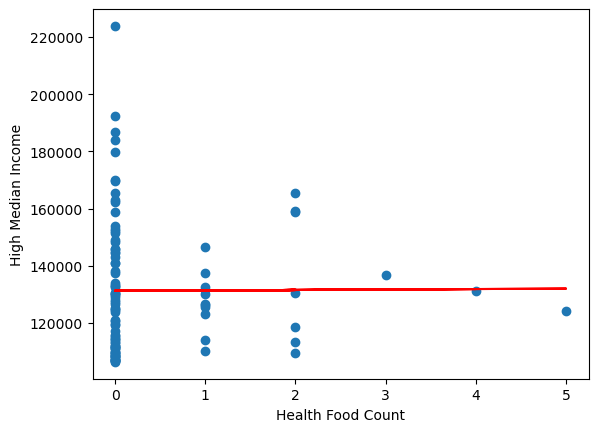

In [32]:
import matplotlib.pyplot as plt
from scipy.stats import linregress
# Add the linear regression equation and line to plot
x_values = high_inc_merged_clean_df["commercial.food_and_drink.health_food Count"]
y_values = high_inc_merged_clean_df["High_med_inc"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(5.8,0.8),fontsize=15,color="red")
plt.xlabel('Health Food Count')
plt.ylabel('High Median Income')
plt.show()

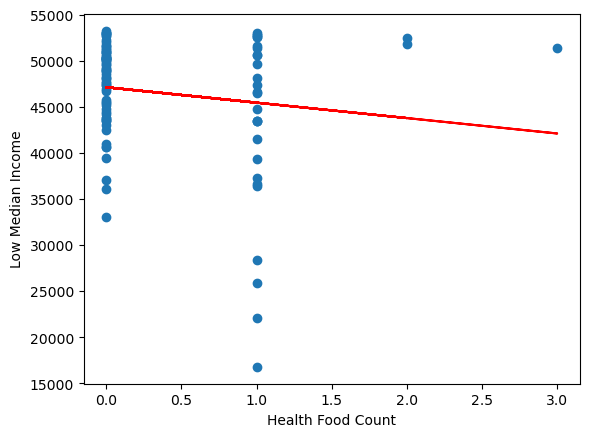

In [33]:
import matplotlib.pyplot as plt
from scipy.stats import linregress
# Add the linear regression equation and line to plot
x_values = low_inc_merged_clean_df["commercial.food_and_drink.health_food Count"]
y_values = low_inc_merged_clean_df["Low_med_inc"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(5.8,0.8),fontsize=15,color="red")
plt.xlabel('Health Food Count')
plt.ylabel('Low Median Income')
plt.show()

What are the average store counts for each category and income level?

In [34]:
# Analyze all cactegories with T - Tests on high vs low income


import scipy.stats as st

# Performing independent t-tests for each category
t_test_weapons = st.ttest_ind(
    low_inc_merged_clean_df['commercial.weapons Count'], 
    high_inc_merged_clean_df['commercial.weapons Count'], 
    equal_var=False)

t_test_sport_club = st.ttest_ind(
    low_inc_merged_clean_df['activity.sport_club Count'], 
    high_inc_merged_clean_df['activity.sport_club Count'], 
    equal_var=False)

t_test_smoking = st.ttest_ind(
    low_inc_merged_clean_df['commercial.smoking Count'], 
    high_inc_merged_clean_df['commercial.smoking Count'], 
    equal_var=False)

t_test_health_food = st.ttest_ind(
    low_inc_merged_clean_df['commercial.food_and_drink.health_food Count'], 
    high_inc_merged_clean_df['commercial.food_and_drink.health_food Count'], 
    equal_var=False)

# Printing average counts and t-test results
print("Average Store Counts:")
print(f"    Weapons - low: {round(low_inc_merged_clean_df['commercial.weapons Count'].mean(),2)}, high: {round(high_inc_merged_clean_df['commercial.weapons Count'].mean(),2)}")
print(f"    Sport Club - low: {round(low_inc_merged_clean_df['activity.sport_club Count'].mean(),2)}, high: {round(high_inc_merged_clean_df['activity.sport_club Count'].mean(),2)}")
print(f"    Smoking - low: {round(low_inc_merged_clean_df['commercial.smoking Count'].mean(),2)}, high: {round(high_inc_merged_clean_df['commercial.smoking Count'].mean(),2)}")
print(f"    Health Food - low: {round(low_inc_merged_clean_df['commercial.food_and_drink.health_food Count'].mean(),2)}, high: {round(high_inc_merged_clean_df['commercial.food_and_drink.health_food Count'].mean(),2)}")

Average Store Counts:
    Weapons - low: 0.29, high: 0.49
    Sport Club - low: 0.61, high: 0.85
    Smoking - low: 3.06, high: 5.96
    Health Food - low: 0.35, high: 0.38


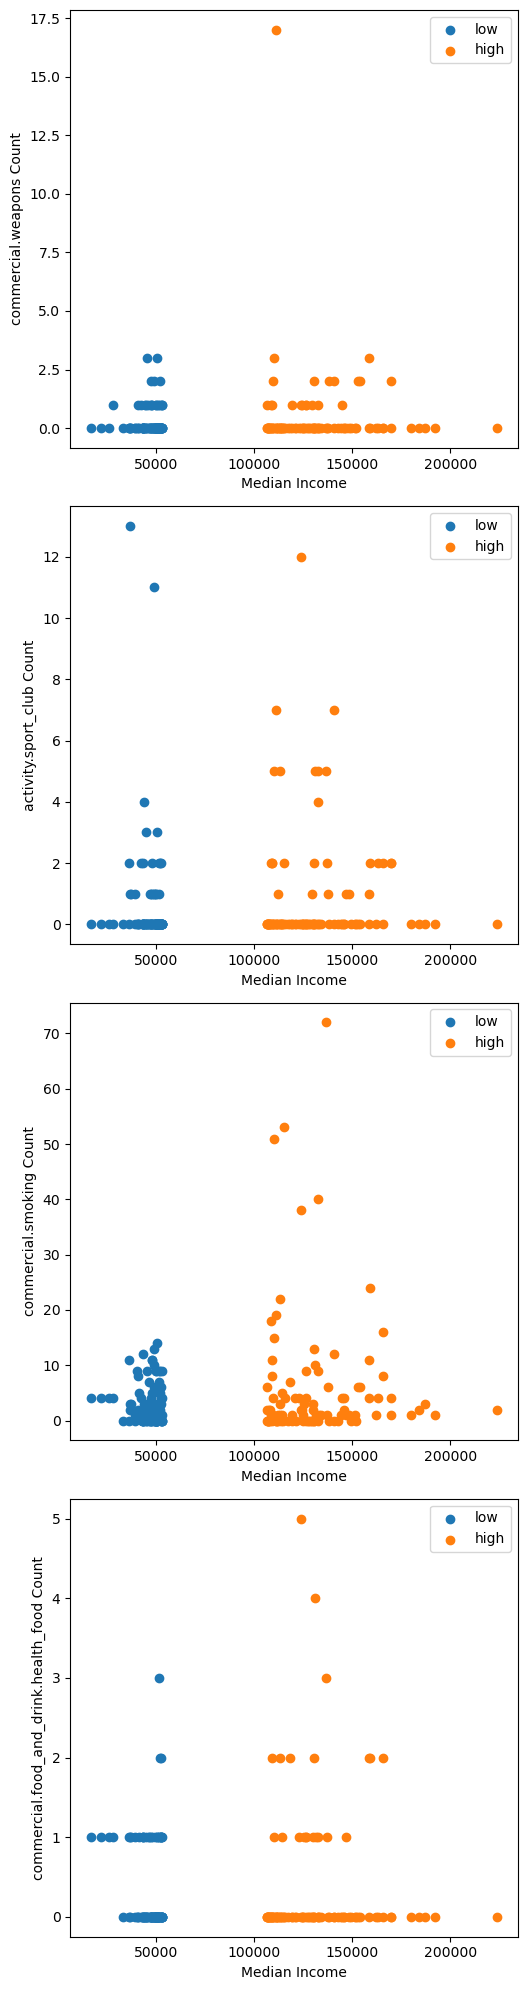

In [35]:
import matplotlib.pyplot as plt

# Visualization of the 3 groups for each category
%matplotlib inline

categories = [ 'commercial.weapons Count', 'activity.sport_club Count', 'commercial.smoking Count', 'commercial.food_and_drink.health_food Count']
num_categories = len(categories)

plt.figure(figsize=(10, num_categories * 5))

for i, category in enumerate(categories, start=1):
    plt.subplot(num_categories, 2, 2 * i - 1)
    plt.scatter(low_inc_merged_clean_df['Low_med_inc'], low_inc_merged_clean_df[category], label="low")
    plt.scatter(high_inc_merged_clean_df['High_med_inc'], high_inc_merged_clean_df[category], label="high")
    plt.xlabel('Median Income')
    plt.ylabel(category)
    plt.legend()


plt.tight_layout()
plt.savefig("../images/ALL_Inc_groups.png")

Lets compare the strongest correlation category of health food stores to the distribution of count across the income high/low and see the availability for these stores per income type.

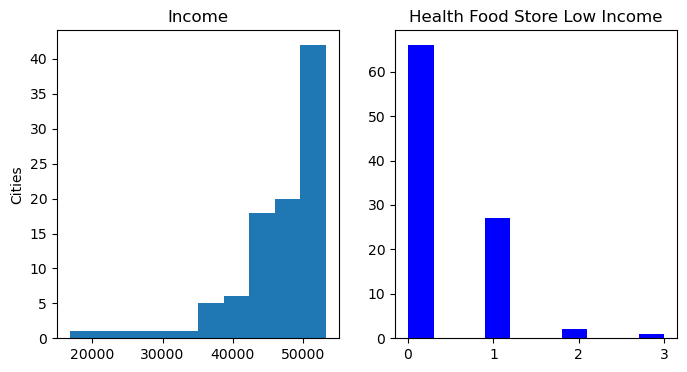

In [41]:
# quick peek of income and liquor store count distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.hist(low_inc_merged_clean_df['Low_med_inc'])
plt.ylabel('Cities')
plt.title('Income')

plt.subplot(1,2,2)
plt.hist(low_inc_merged_clean_df['commercial.food_and_drink.health_food Count'], color='blue')
plt.title('Health Food Store Low Income')

plt.savefig("../images/Health_Food_Distribution_low.png")

plt.show()

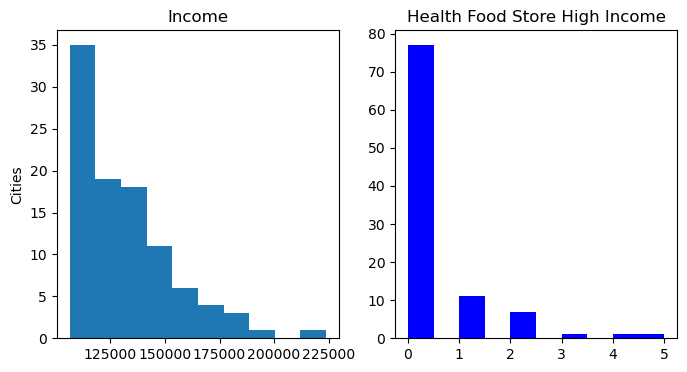

In [42]:
# quick peek of income and liquor store count distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.hist(high_inc_merged_clean_df['High_med_inc'])
plt.ylabel('Cities')
plt.title('Income')

plt.subplot(1,2,2)
plt.hist(high_inc_merged_clean_df['commercial.food_and_drink.health_food Count'], color='blue')
plt.title('Health Food Store High Income')

plt.savefig("../images/Health_Food_Distribution_high.png")

plt.show()

Here you can see that there are more options available for health food stores at higher income, although it appears there are more cities without a health food store nearby. Since this is a small radius, and geographically complex comparison, the indication of more options in stores at higher income is important to note. Also, the correlation does indicate the lower income has less options.